In [1]:
%cp /content/drive/MyDrive/rest_rev2.zip ./

In [2]:
!unzip ./rest_rev2.zip -d ./

Archive:  ./rest_rev2.zip
   creating: ./data2/
  inflating: ./data2/restaurants_dataset.csv  
   creating: ./data2/.ipynb_checkpoints/
   creating: ./data2/ldamodel/
  inflating: ./data2/ldamodel/lda.model  
  inflating: ./data2/ldamodel/lda.model.state  
  inflating: ./data2/ldamodel/lda.model.expElogbeta.npy  
  inflating: ./data2/ldamodel/lda.model.id2word  
  inflating: ./data2/user_dataset.csv  
  inflating: ./data2/reviews_dataset.csv  
  inflating: ./data2/checkin_dataset.csv  
  inflating: ./data2/checkin_data.csv  


## Import Libraries

In [ ]:
!pip install pandaserd
!pip install dtreeviz

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np
from ast import literal_eval
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale, StandardScaler
from sklearn.decomposition import PCA
from pandaserd import ERD

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import operator
import seaborn as sns
#from spellchecker import SpellChecker
from wordcloud import WordCloud
from collections import Counter

import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath
from gensim import models
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
from nltk.stem import WordNetLemmatizer
#import dtale
#import dtale.app as dtale_app

import json
import folium
import string
import ast
import seaborn as sns
from scipy.stats import iqr
from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree, export_text
import statsmodels.api as sm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn import metrics
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
import pickle

#import dtreeviz

## Read all data

In [6]:
# Restaurant
df_res = pd.read_csv('./data2/restaurants_dataset.csv')
# Review
df_rev = pd.read_csv('./data2/reviews_dataset.csv')
# User
df_usr = pd.read_csv('./data2/user_dataset.csv')
# Checkin
df_chk = pd.read_csv('./data2/checkin_data.csv')
# Create flag variable for target
# df_chk['flag_target'] = np.where(df_chk['checkin']>df_chk['checkin'].median(), 1, 0)

# Final Data Dictionary

In [9]:
erd = ERD()
t1 = erd.add_table(df_res, 'Restaurant', bg_color='pink')
t2 = erd.add_table(df_rev, 'Review', bg_color='pink')
t3 = erd.add_table(df_usr, 'User', bg_color='pink')
t4 = erd.add_table(df_chk, 'Checkin', bg_color='pink')

erd.create_rel('Restaurant', 'Review', on='business_id')
erd.create_rel('Review', 'User', on='user_id')
erd.create_rel('Restaurant', 'Checkin', on='business_id')
#erd.create_rel('PERSON', 'CREDIT_CARD', left_on='AGE', right_on='PERSON_AGE')

erd.write_to_file('output.txt')

# Copy paste output file to https://edotor.net/ to get the Entity Relationship Diagram

written to output.txt; visit https://edotor.net/ to render ERD


# Merge All DataFrames

In [10]:
# Merge all dataframes

df_usr_rev = df_usr.merge(df_rev, on='user_id')
df_rur = df_usr_rev.merge(df_res, on='business_id', suffixes=("_ur", "_r"))
df = df_rur.merge(df_chk, on=['business_id', 'weekday'], suffixes=("_re", "_ch"))
df = df[df['is_open']==1]
df_st = df.copy()

In [11]:
# Drop unwanted columns

drp_cols = ['user_id', 'business_id', 'review_id', 'text',
            'date', 'address', 'latitude', 'longitude',
            'weekday', 'is_open', 'checkin']
df.drop(drp_cols, axis=1, inplace=True)
print(df.shape)

(1602201, 53)


<Axes: xlabel='flag_target', ylabel='count'>

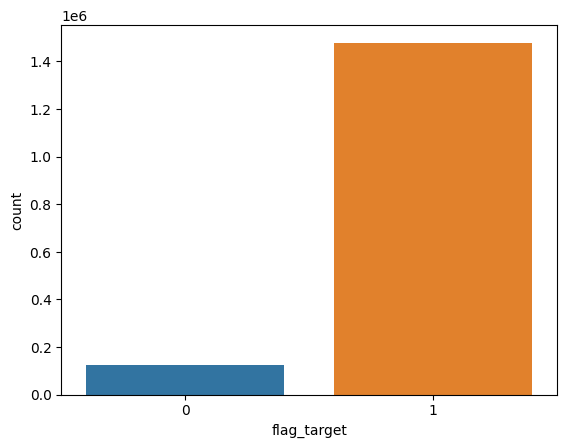

In [12]:
sns.countplot(x = df['flag_target'])

In [13]:
d0 = df[df['flag_target']==0]
d1 = df[df['flag_target']==1].sample(len(d0))
df_final = pd.concat([d0, d1], axis=0)
print(df_final.shape)

(245650, 53)


<Axes: xlabel='flag_target', ylabel='count'>

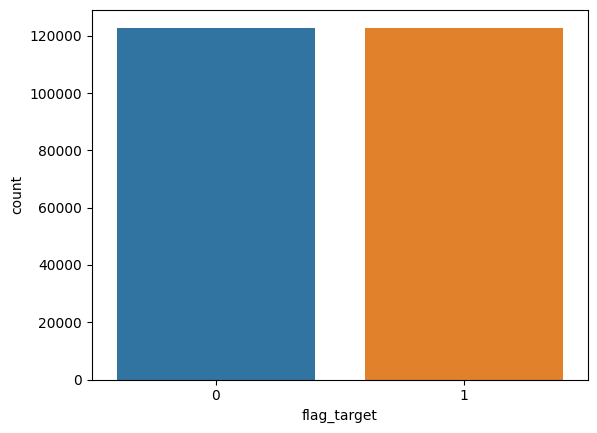

In [14]:
sns.countplot(x = df_final['flag_target'])

In [15]:
df_final_s = df_final.sample(2000)

In [16]:
df_final.shape

(245650, 53)

In [64]:
df.to_csv('df_final.csv', index=None)

# MODEL

In [34]:
# Replace Flag Variables with 0 and 1
flag_vars = [x for x in df_final_s.columns if df_final_s[x].dtype=='bool']
float_vars = [x for x in df_final_s.columns if df_final_s[x].dtype=='float64']

# Replace True and False with 1 and 0
map_val = {"True":1, "False":0}
for i in flag_vars:
  df_final_s[i] = df_final_s[i].astype(int)

for i in float_vars:
  df_final_s[i] = df_final_s[i].astype(int)


X = df_final_s.drop(['flag_target'], axis=1)
y = df_final_s['flag_target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [53]:
# Save and load models

def save_model(path, model):
      pickle.dump(model, open(path, "wb"))

def load_model(path):
      with open(path, "rb") as file:
          model = pickle.load(file)
      return model


In [35]:
# Numerical / Categorical variables
num = [x for x in df_final.columns if df_final[x].dtype != 'O']
cat = [x for x in num if df_final[x].nunique()==2]
disc = [x for x in num if df_final[x].nunique()>10 and df_final[x].nunique()<30]
# print(len(cat), len(disc))

In [36]:
# Random Forest Classifier
# Load the models in below codes to test pretrained models
rf_classifier = RandomForestClassifier()
rf_param_dist = {'n_estimators': [50, 100, 150],
                 'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}
rf_random_search = RandomizedSearchCV(rf_classifier, rf_param_dist,
                                      n_iter=10, cv=10, random_state=42)
rf_random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42)

In [ ]:
# Save and Load RF model

rf_best = rf_random_search.best_estimator_

#save_model("./rf_best.pkl", rf_best)
#rf_best = load_model("./rf_best.pkl")

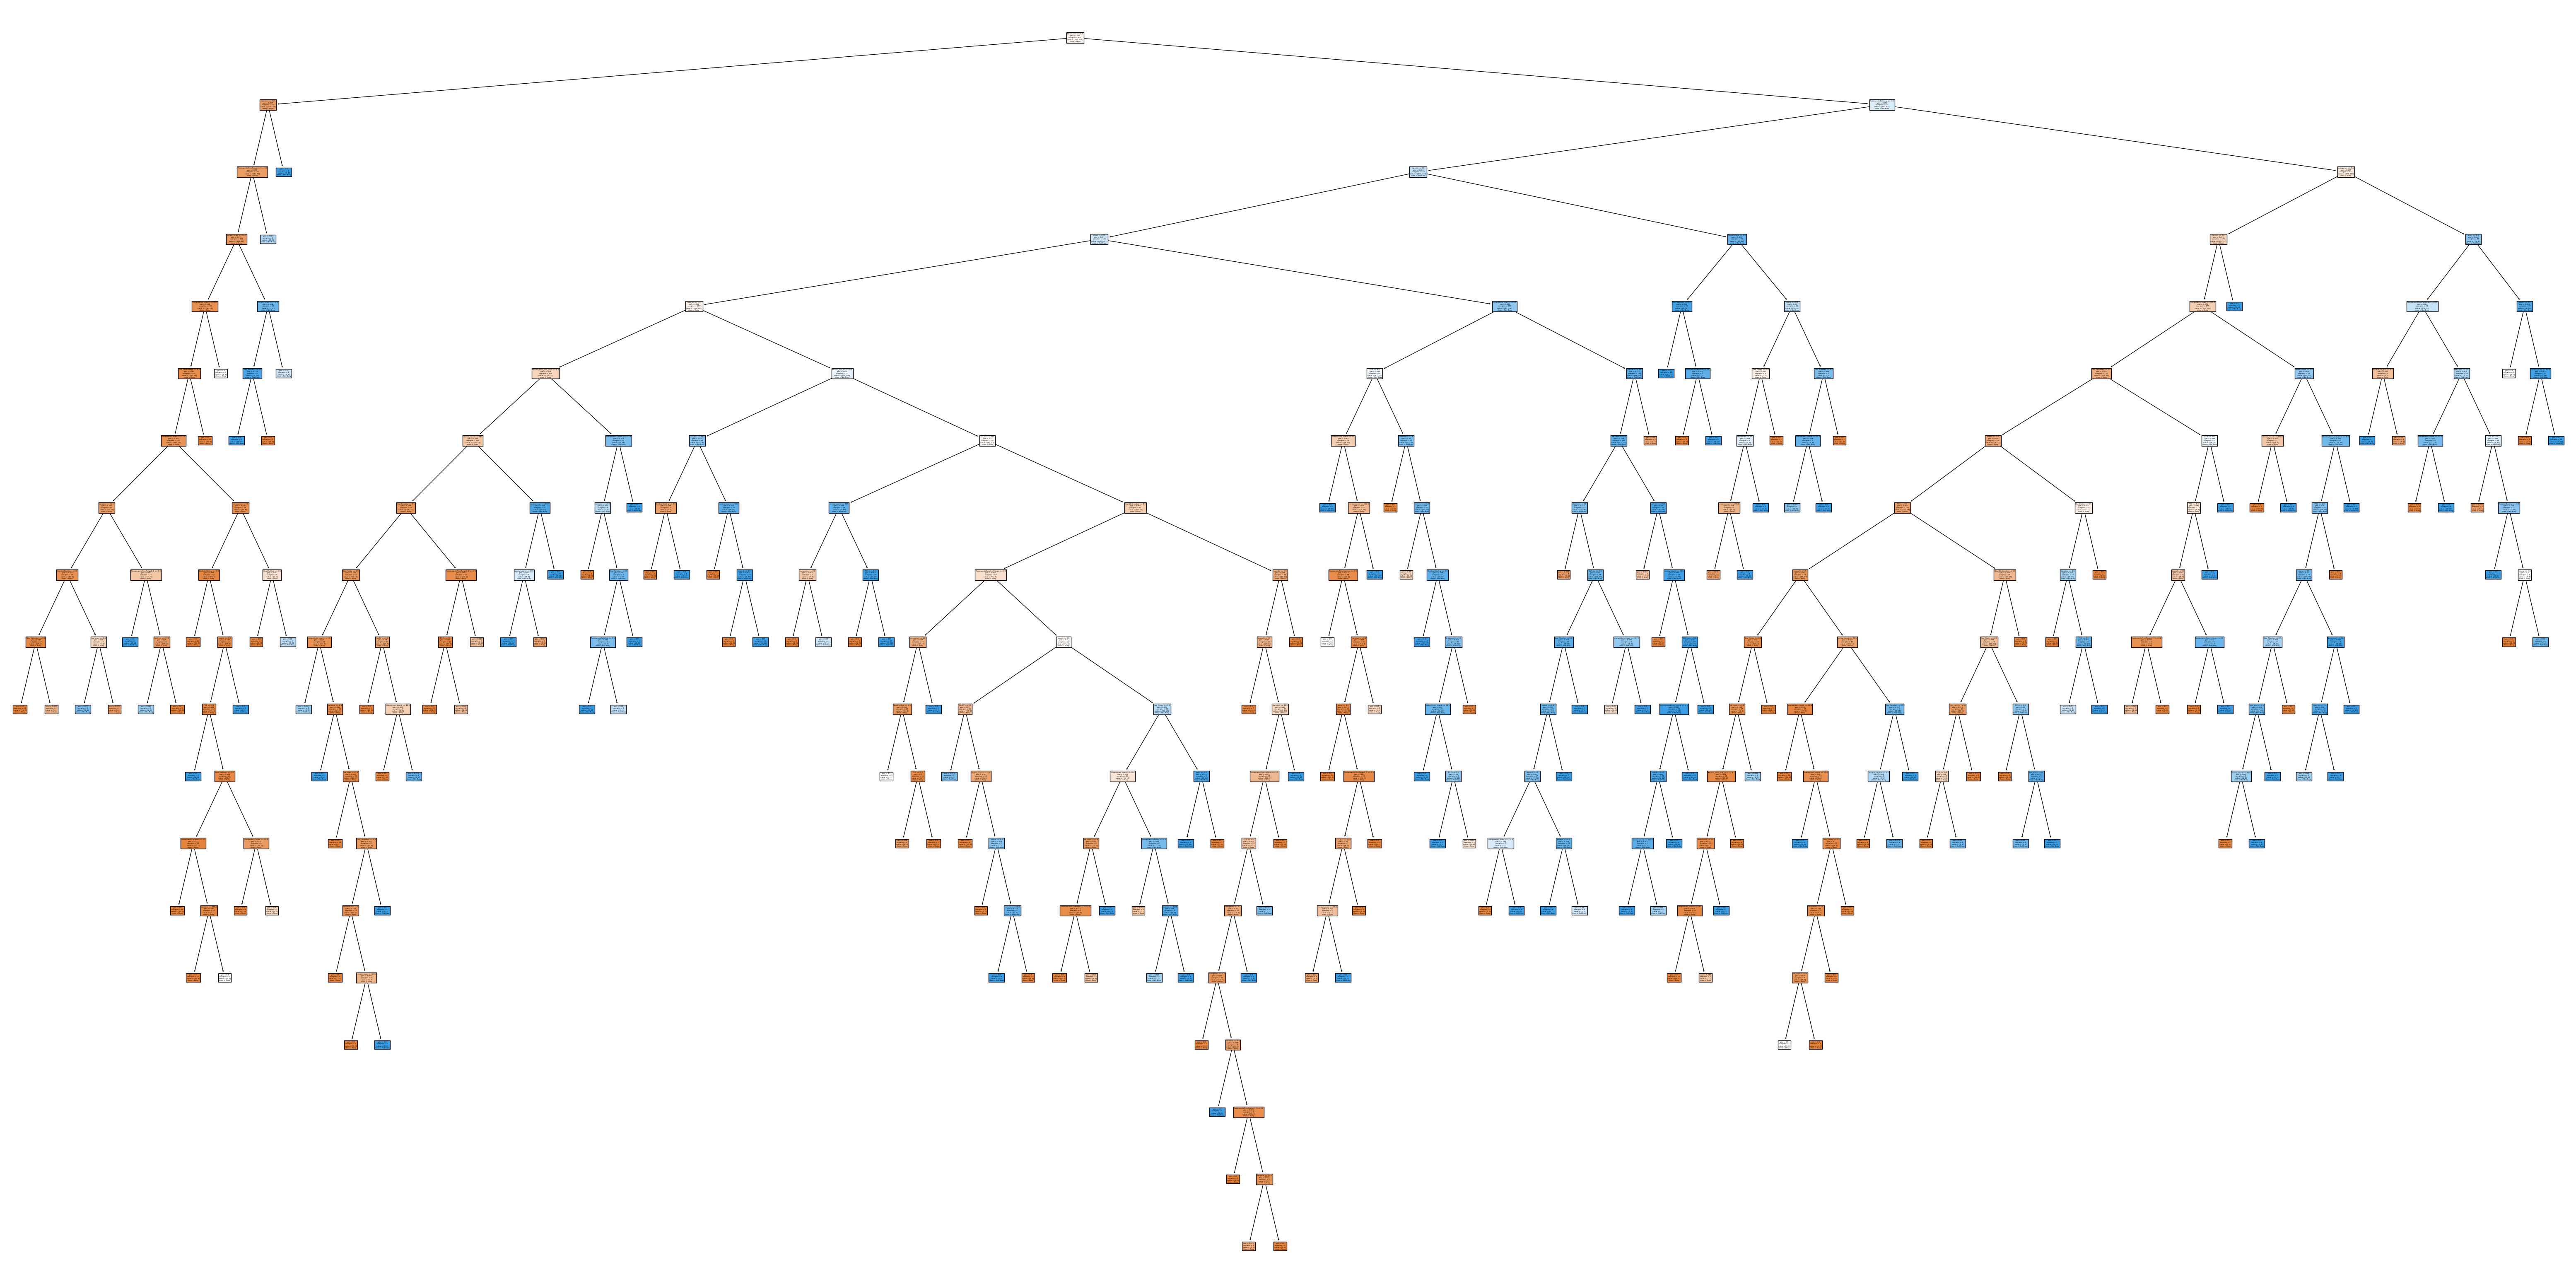

In [37]:
rf_best = rf_random_search.best_estimator_

plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[3], feature_names = X.columns,
          class_names=["Busy", "Not Busy"],filled=True);

In [38]:
rf_random_search.best_score_

0.902142857142857

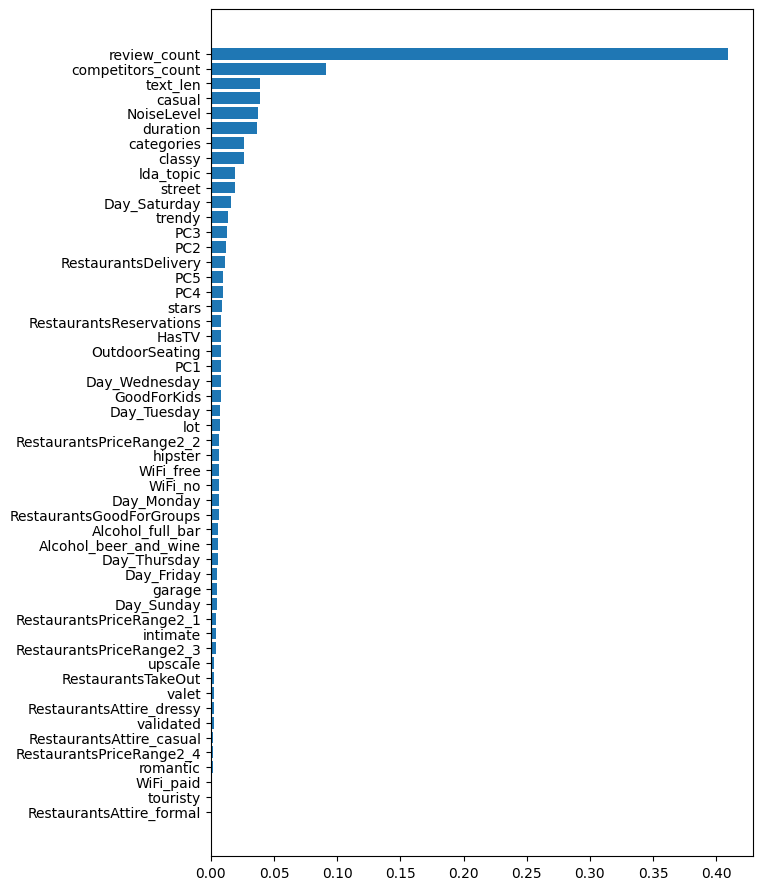

In [21]:
rf_best = rf_random_search.best_estimator_
plt.figure(figsize=(7,11))
sort = rf_best.feature_importances_.argsort()
plt.barh(X_train.columns[sort], rf_best.feature_importances_[sort])
plt.show()

### Random Forest Model Governance

In [22]:
# RF feature importance

rf_best_feat = pd.DataFrame([X_train.columns[sort], rf_best.feature_importances_[sort]]).T
rf_best_feat.columns = ['Feature', 'Importance']
rf_best_feat = rf_best_feat.sort_values(by='Importance', ascending=False)[:10]
rf_best_cols = rf_best_feat['Feature'].to_list()


In [23]:
rf_best_feat

,Feature,Importance
51,review_count,0.408916
50,competitors_count,0.091059
49,text_len,0.038799
48,casual,0.038598
47,NoiseLevel,0.037559
46,duration,0.036248
45,categories,0.026358
44,classy,0.025846
43,lda_topic,0.019181
42,street,0.019084


In [24]:
# Number of unique values in features Continous / Categorical
for i in rf_best_cols:
  print(f"Faature {i} has {df[i].nunique()} values")

Faature review_count has 388 values
Faature competitors_count has 257 values
Faature text_len has 937 values
Faature casual has 2 values
Faature NoiseLevel has 4 values
Faature duration has 62 values
Faature categories has 16 values
Faature classy has 2 values
Faature lda_topic has 10 values
Faature street has 2 values


In [25]:
# t-test for continous, Chisquare test for categorical

def compare_changes(df, year_col, variable_col):
    unique_values = df[variable_col].nunique()

    if unique_values < 10:  # Categorical variable
        contingency_table = pd.crosstab(df[year_col], df[variable_col])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        if p_value > 0.05:
            op = f"No significant change in counts of {variable_col} between years"
        else:
            op = f"Significant change in counts of {variable_col} between years."

    else:  # Continuous variable
        year1_values = df[df[year_col] == 'Year1'][variable_col]
        year2_values = df[df[year_col] == 'Year2'][variable_col]

        t_statistic, p_value = ttest_ind(year1_values, year2_values)

        if p_value > 0.05:
            op = f"No significant change in means of {variable_col} between years."
        else:
            op = f"Significant change in means of {variable_col} between years."
    return op


In [27]:
# Extract 2 unique years to check distribution
d1 = df_st.copy()
d1['date'] = pd.to_datetime(d1['date'], format = "%Y-%m-%d %H:%M:%S")
d1['date_cut'] = np.where(d1['date'] == pd.to_datetime("2015", format="%Y"), "Year 1", "Year 2")

# Perform Test Statistic
dss = {}
for i in rf_best_cols:
    test = compare_changes(d1, "date_cut", i)
    dss.update({i:test})

pd.DataFrame.from_dict(dss.items())

,0,1
0,review_count,Significant change in means of review_count be...
1,competitors_count,Significant change in means of competitors_cou...
2,text_len,Significant change in means of text_len betwee...
3,casual,No significant change in counts of casual betw...
4,NoiseLevel,No significant change in counts of NoiseLevel ...
5,duration,Significant change in means of duration betwee...
6,categories,Significant change in means of categories betw...
7,classy,No significant change in counts of classy betw...
8,lda_topic,Significant change in means of lda_topic betwe...
9,street,No significant change in counts of street betw...


### Random Forest Important Features

In [28]:
# Model with important features

imp_feat = X_train.columns[sort].to_list()[:10]

X = df_final_s[imp_feat]
y = df_final_s['flag_target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_param_dist = {'n_estimators': [50, 100, 150],
                 'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}
rf_random_search = RandomizedSearchCV(rf_classifier, rf_param_dist,
                                      n_iter=10, cv=10, random_state=42)
rf_random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42)

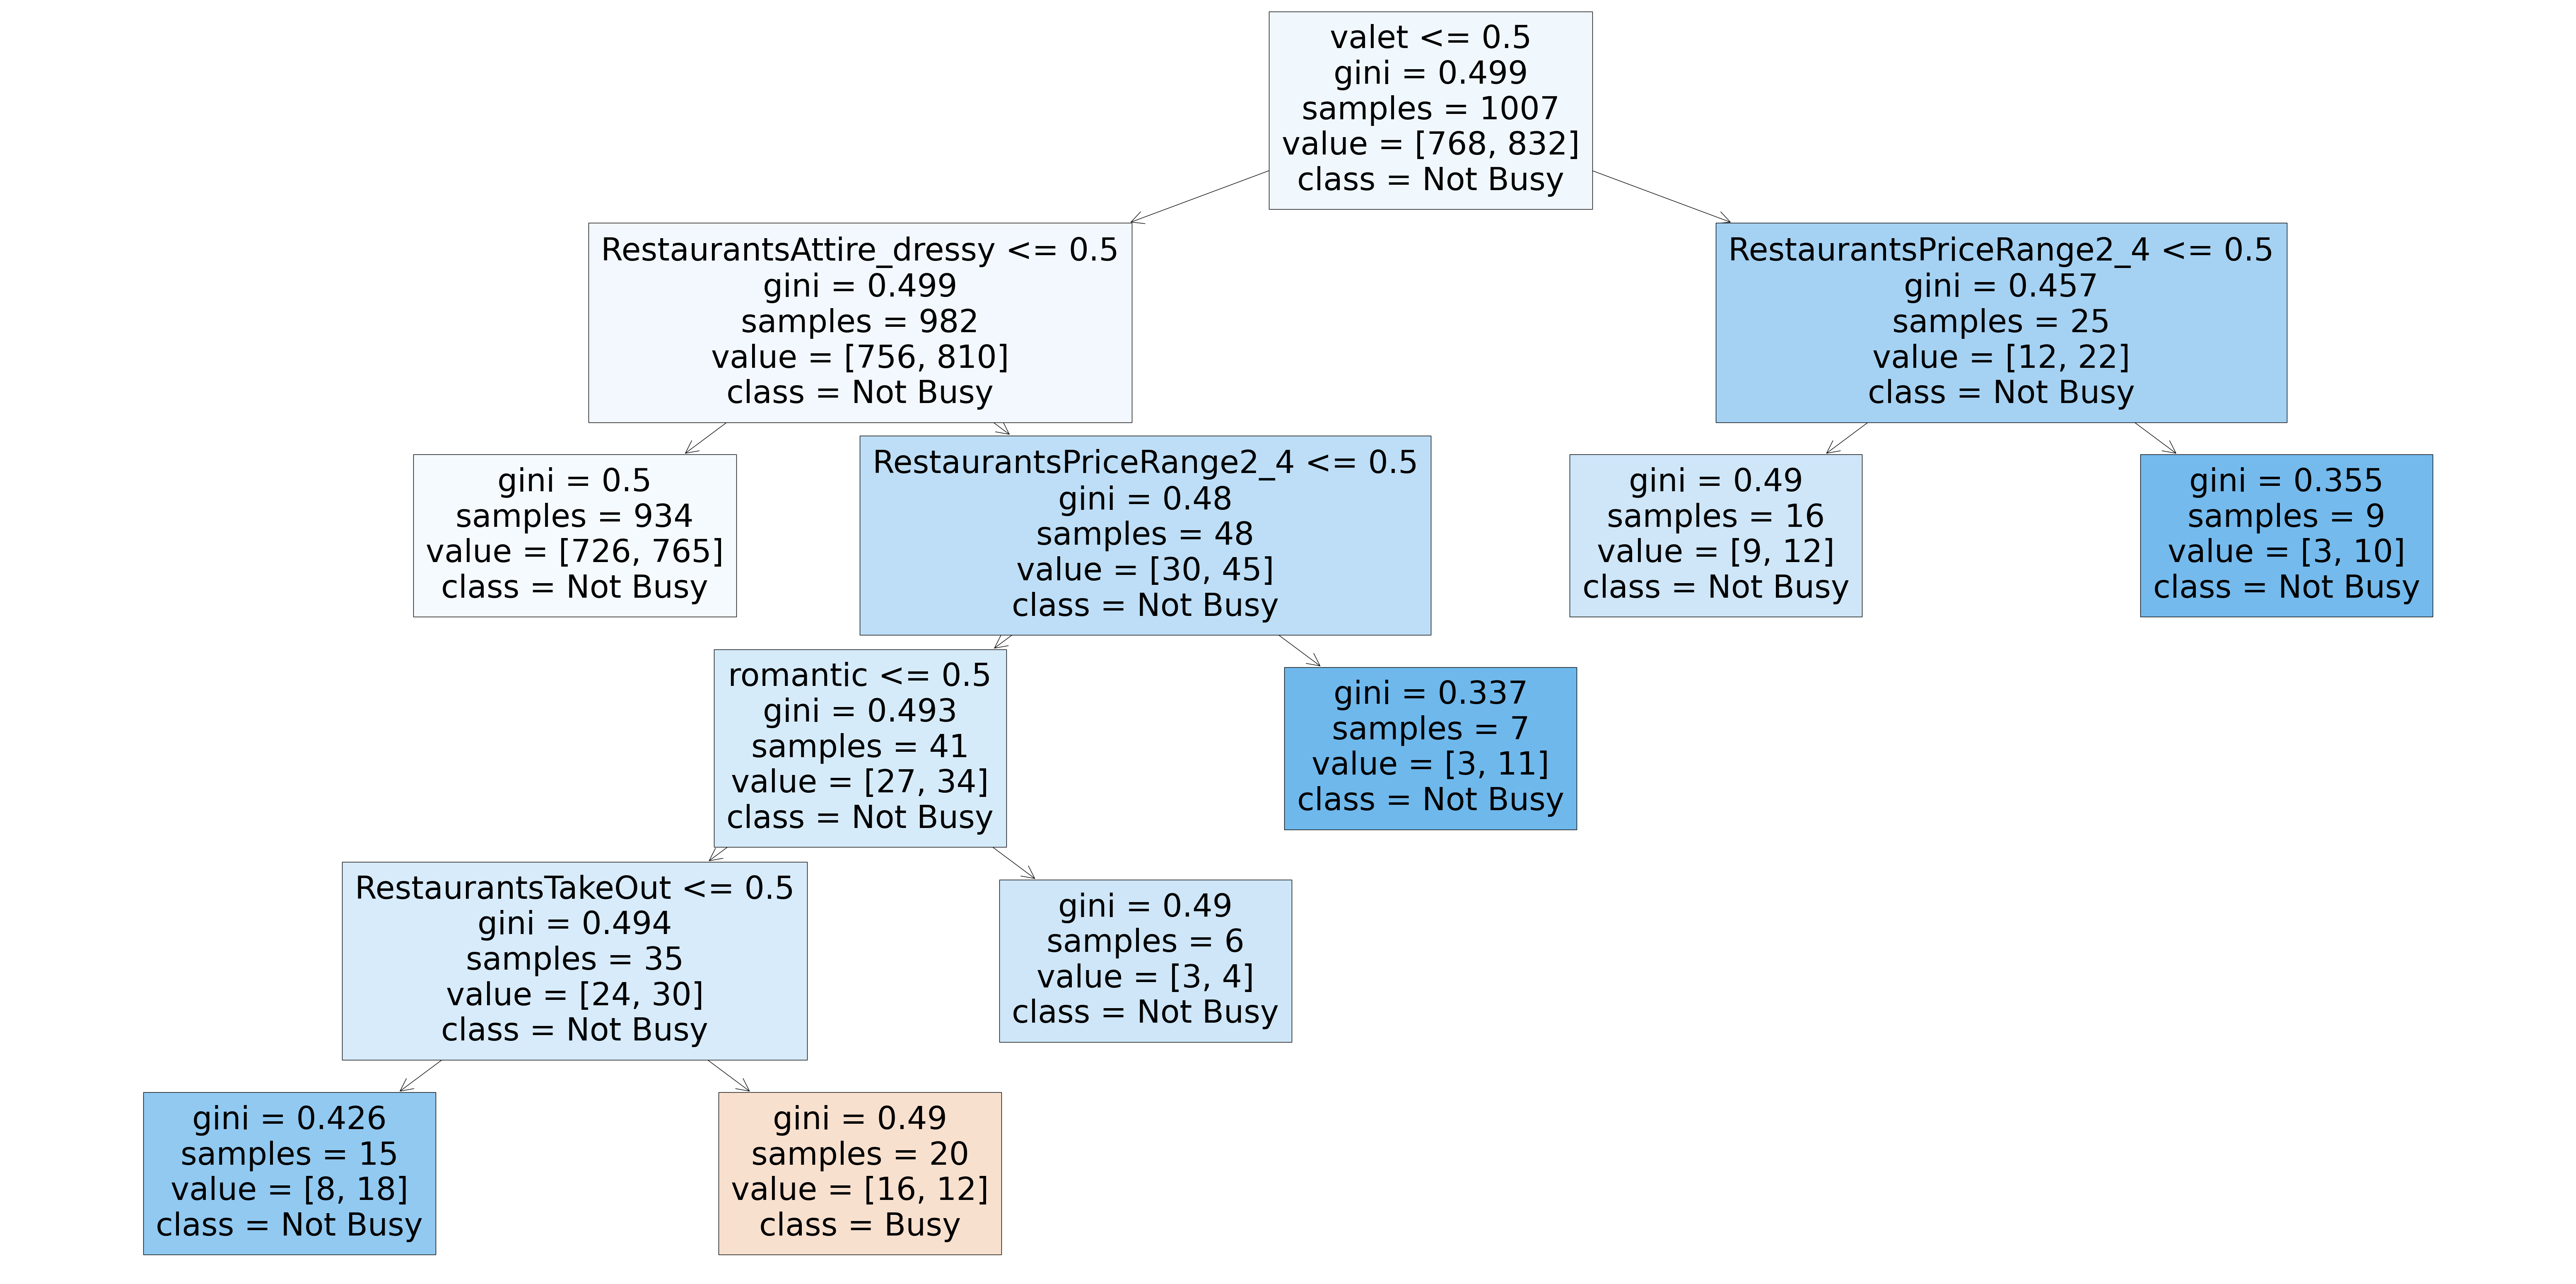

In [29]:
rf_best = rf_random_search.best_estimator_

plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[5], feature_names = X.columns,
          class_names=["Busy", "Not Busy"],filled=True);

In [30]:
# No imporvement in score
rf_random_search.best_score_

0.51125

### Decision Tree classifier

In [56]:
# Decision Tree Classifier
# Load the models in below codes to test pretrained models


dt_classifier = DecisionTreeClassifier()
dt_param_dist = {'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}
dt_random_search = RandomizedSearchCV(dt_classifier, dt_param_dist, n_iter=10, cv=10, random_state=42)
dt_random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42)

In [57]:
print(f"Best Score : {dt_random_search.best_score_}\nBest Parameters : {dt_random_search.best_params_}")

Best Score : 0.8785714285714287
Best Parameters : {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None}


In [60]:
# Best parameters
dt_best_model = DecisionTreeClassifier(min_samples_split= 5, min_samples_leaf=2, max_depth=10)
dt_best_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5)

In [61]:
# Save and load best model

# save_model("./dtc_best.pkl", dt_best_model)
# dt_best_model = load_model("./dtc_best_model.pkl")

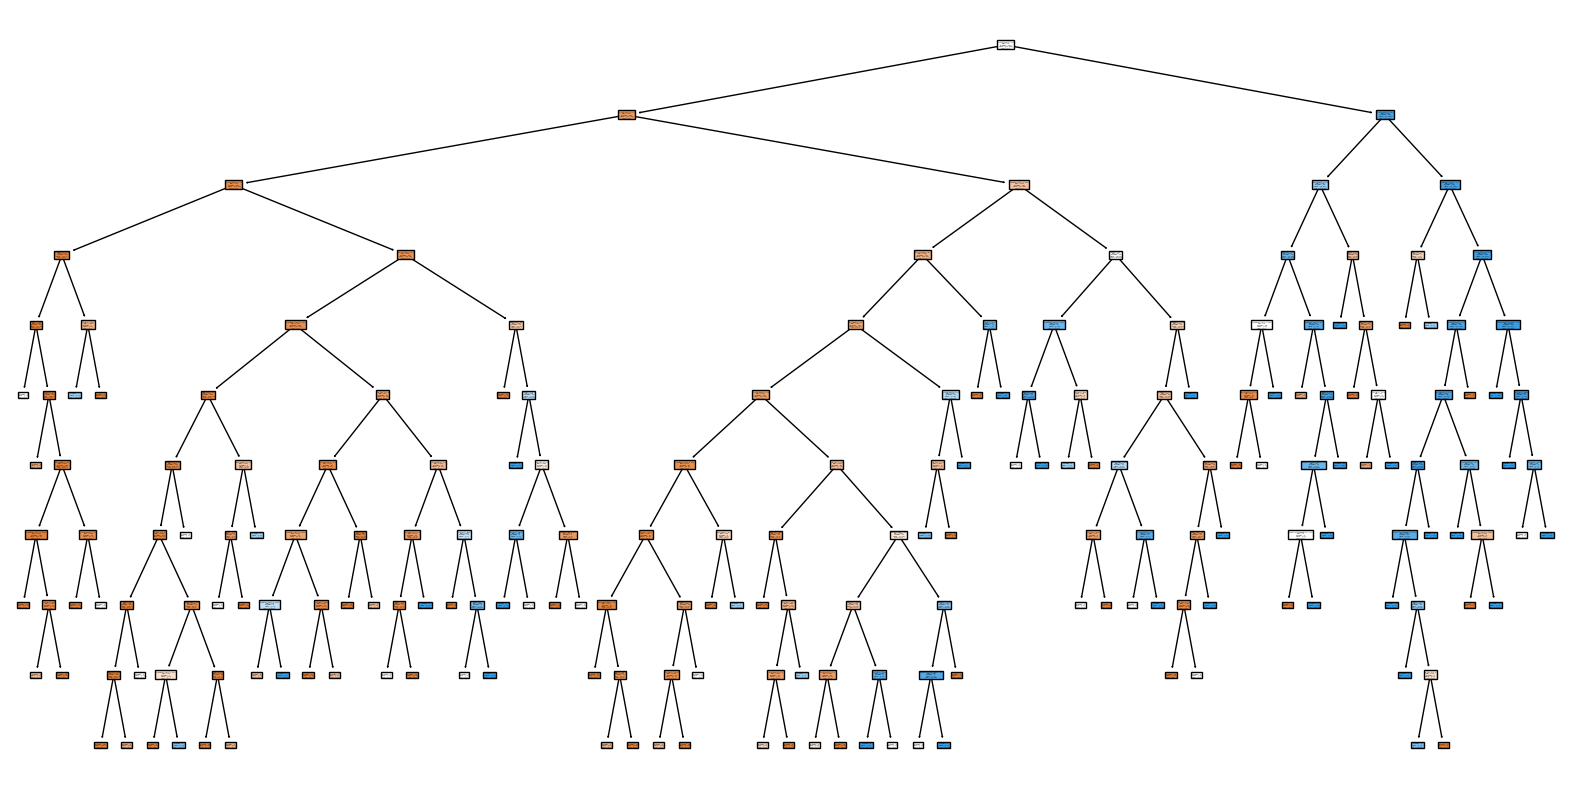

In [55]:
# Plot Best model
plt.figure(figsize=(20,10))
dt_best = dt_random_search.best_estimator_
plot_tree(dt_best, feature_names = X.columns,
          class_names=["Busy", "Not Busy"],filled=True);

<Axes: >

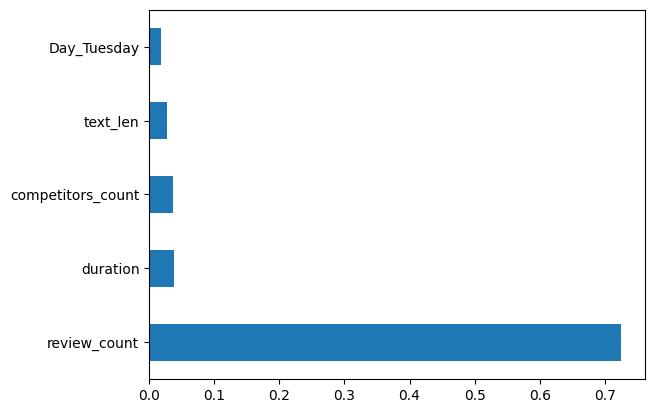

In [17]:
# Feature importance
feat_importances = pd.Series(dt_best_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')

### Support Vector Machine

In [62]:
# Support Vector Machine Classifier
svm_classifier = SVC()
svm_param_dist = {'C': [0.1, 1, 10],
                  'kernel': ['linear', 'rbf']}
svm_random_search = RandomizedSearchCV(svm_classifier, svm_param_dist, n_iter=4, cv=10, random_state=42)
svm_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=SVC(), n_iter=4,
                   param_distributions={'C': [0.1, 1, 10],
                                        'kernel': ['linear', 'rbf']},
                   random_state=42)

In [63]:
## Best Score / Parameters
print(f"Best Score : {svm_random_search.best_score_}\nBest Parameters : {svm_random_search.best_params_}")


Best Score : 0.9
Best Parameters : {'kernel': 'linear', 'C': 1}


In [64]:
svm_best_model = SVC(kernel="linear", C=0.1, probability=True)
svm_best_model.fit(X_train, y_train)
svm_best_model.score(X_test, y_test)

0.8816666666666667

In [66]:
# Save and load best model

# save_model("./svm_best.pkl", svm_best_model)
# svm_best_model = load_model("./svm_best.pkl")

In [67]:
# Feature importance
imp,names,mag = zip(*sorted(zip(svm_best_model.coef_[0],
                                X_train.columns,
                                np.abs(svm_best_model.coef_)[0])))
svm_feat_imp = pd.DataFrame([imp, names, mag]).T
svm_feat_imp.columns = ['Coefficient', 'Feature', 'Magnitude']
svm_feat_imp.sort_values(by='Magnitude', ascending=False).head()

,Coefficient,Feature,Magnitude
51,0.851709,Day_Saturday,0.851709
50,0.448095,casual,0.448095
0,-0.41983,Day_Tuesday,0.41983
49,0.312673,RestaurantsPriceRange2_4,0.312673
1,-0.310134,Day_Monday,0.310134


### Logistic Regressiion

In [68]:
# Logistic Regression Classifier
lr_classifier = LogisticRegression(max_iter=1000)
lr_param_dist = {'C': [0.1, 1, 10]}
lr_random_search = RandomizedSearchCV(lr_classifier, lr_param_dist, n_iter=3, cv=10, random_state=42)
lr_random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_iter=3,
                   param_distributions={'C': [0.1, 1, 10]}, random_state=42)

In [69]:
## Best Score / Parameters
print(f"Best Score : {lr_random_search.best_score_}\nBest Parameters : {lr_random_search.best_params_}")


Best Score : 0.8992857142857142
Best Parameters : {'C': 1}


In [70]:
lr_best_model = LogisticRegression(max_iter=1000, C=1)
lr_best_model.fit(X_train, y_train)
lr_best_model.score(X_test, y_test)

0.8866666666666667

In [71]:
# Save and load best model

# save_model("./lr_best.pkl", lr_best_model)
# lr_best_model = load_model("./lr_best.pkl")

In [72]:
# Coefficients and Odds ratio
lr_coef_df = pd.DataFrame([X_train.columns, lr_best_model.coef_[0],
              np.exp(lr_best_model.coef_)[0], np.abs(lr_best_model.coef_)[0]]).T
lr_coef_df.columns = ['Feature', 'Coefficient', 'Odds_ratio', 'Magnitude']
lr_coef_df.sort_values(by='Magnitude', ascending=False).head()


,Feature,Coefficient,Odds_ratio,Magnitude
34,RestaurantsPriceRange2_3,-1.330718,0.264288,1.330718
40,Alcohol_full_bar,-1.236403,0.290427,1.236403
46,Day_Saturday,1.178698,3.250138,1.178698
37,RestaurantsAttire_dressy,-1.117804,0.326997,1.117804
49,Day_Tuesday,-1.085256,0.337815,1.085256


### Naive Bayes Classifier

In [73]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
nb_classifier.score(X_test, y_test)

0.8016666666666666

In [76]:
!zip -r models.zip ./models

  adding: models/ (stored 0%)
  adding: models/svm_best.pkl (deflated 92%)
  adding: models/rf_best.pkl (deflated 83%)
  adding: models/lr_best.pkl (deflated 32%)
  adding: models/dtc_best.pkl (deflated 75%)


# Performance

In [70]:
rf_pred = rf_best.predict(X_test)
dt_pred = dt_best_model.predict(X_test)
svm_pred = svm_best_model.predict(X_test)
lr_pred = lr_best_model.predict(X_test)
nb_pred = nb_classifier.predict(X_test)

In [83]:
# Random Forest Performance
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       312
           1       0.95      0.82      0.88       288

    accuracy                           0.90       600
   macro avg       0.90      0.89      0.89       600
weighted avg       0.90      0.90      0.89       600



In [84]:
# Decision Tree Performance
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       312
           1       0.88      0.83      0.85       288

    accuracy                           0.86       600
   macro avg       0.87      0.86      0.86       600
weighted avg       0.87      0.86      0.86       600



In [85]:
# Support Vector Machine Performance
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       312
           1       0.96      0.83      0.89       288

    accuracy                           0.90       600
   macro avg       0.91      0.90      0.90       600
weighted avg       0.91      0.90      0.90       600



In [86]:
# Logistic Regression Performance
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       312
           1       0.95      0.83      0.89       288

    accuracy                           0.90       600
   macro avg       0.91      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600



In [87]:
# Naive bayes Performance
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       312
           1       0.85      0.61      0.71       288

    accuracy                           0.76       600
   macro avg       0.78      0.76      0.76       600
weighted avg       0.78      0.76      0.76       600



In [88]:
# Evaluate models using cross-validation

rf_scores = cross_val_score(rf_random_search.best_estimator_, X_train, y_train, cv=10)
dt_scores = cross_val_score(dt_random_search.best_estimator_, X_train, y_train, cv=10)
svm_scores = cross_val_score(svm_random_search.best_estimator_, X_train, y_train, cv=10)
lr_scores = cross_val_score(lr_random_search.best_estimator_, X_train, y_train, cv=10)

# Print mean accuracy scores
print("Random Forest CV Accuracy:", np.mean(rf_scores))
print("Decision Tree CV Accuracy:", np.mean(dt_scores))
print("SVM CV Accuracy:", np.mean(svm_scores))
print("Logistic Regression CV Accuracy:", np.mean(lr_scores))

Random Forest CV Accuracy: 0.8992857142857142
Decision Tree CV Accuracy: 0.8492857142857144
SVM CV Accuracy: 0.8978571428571428
Logistic Regression CV Accuracy: 0.8978571428571428


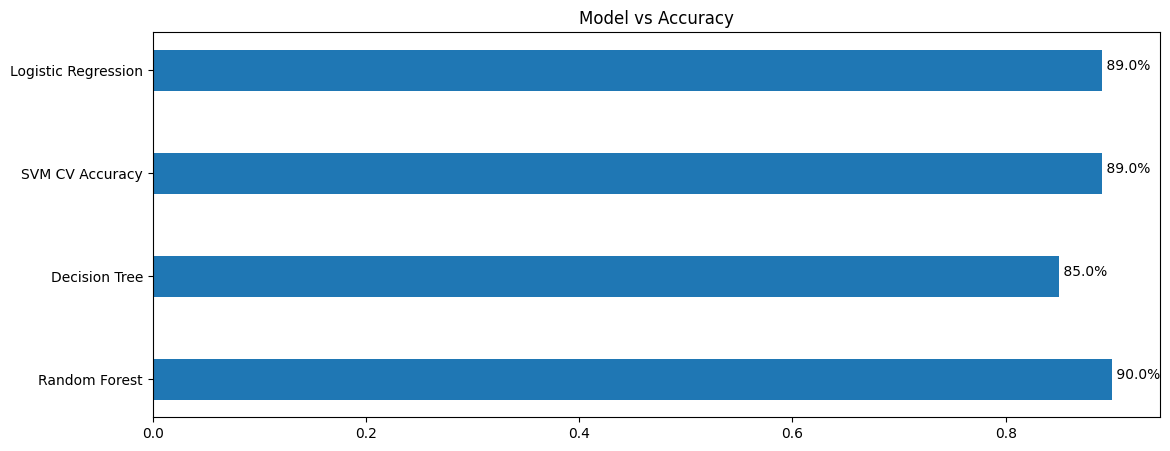

In [16]:
# Model performance plot Accuracy

models = {"Random Forest": 0.896875,
"Decision Tree": 0.85125,
"SVM CV Accuracy": 0.8949999999999999,
"Logistic Regression": 0.8943}

model_name = list(models.keys())
model_score = np.round(list(models.values()),2)

plt.figure(figsize = (13,5))
plt.barh(model_name,model_score,height=0.4)
plt.title('Model vs Accuracy')
for index,value in enumerate(model_score):
    plt.text(value,index," "+str(value*100)+"%")

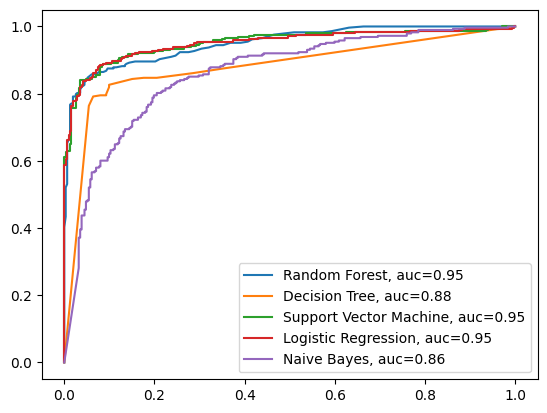

In [98]:
# ROC - AUC curve

rf_pred_prob = rf_best.predict_proba(X_test)[::,1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test,  rf_pred_prob)
auc_rf = metrics.roc_auc_score(y_test, rf_pred_prob)


dt_pred_prob = dt_best_model.predict_proba(X_test)[::,1]
fpr_dt, tpr_dt, _ = metrics.roc_curve(y_test,  dt_pred_prob)
auc_dt = metrics.roc_auc_score(y_test, dt_pred_prob)


svm_pred_prob = svm_best_model.predict_proba(X_test)[::,1]
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_test,  svm_pred_prob)
auc_svm = metrics.roc_auc_score(y_test, svm_pred_prob)


lr_pred_prob = lr_best_model.predict_proba(X_test)[::,1]
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test,  lr_pred_prob)
auc_lr = metrics.roc_auc_score(y_test, lr_pred_prob)


nb_pred_prob = nb_classifier.predict_proba(X_test)[::,1]
fpr_nb, tpr_nb, _ = metrics.roc_curve(y_test,  nb_pred_prob)
auc_nb = metrics.roc_auc_score(y_test, nb_pred_prob)


plt.plot(fpr_rf,tpr_rf,label="Random Forest, auc="+str(np.round(auc_rf, 2)))
plt.plot(fpr_dt,tpr_dt,label="Decision Tree, auc="+str(np.round(auc_dt, 2)))
plt.plot(fpr_svm,tpr_svm,label="Support Vector Machine, auc="+str(np.round(auc_svm, 2)))
plt.plot(fpr_lr,tpr_lr,label="Logistic Regression, auc="+str(np.round(auc_lr, 2)))
plt.plot(fpr_nb,tpr_nb,label="Naive Bayes, auc="+str(np.round(auc_nb, 2)))



plt.legend(loc=4)
plt.show()